In [0]:
!pip install geopandas

     |████████████████████████████████| 931kB 3.5MB/s 
     |████████████████████████████████| 14.7MB 245kB/s 
     |████████████████████████████████| 10.9MB 48.6MB/s 


In [0]:
!apt install libspatialindex-dev
!pip install rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig

from rtree import index
from rtree.index import Rtree

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0  1067k      0 --:--:-- --:--:-- --:--:-- 1067k
checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether ln -s works... yes
checking whether make sets $(MAKE)... yes
checking host system type... x86_64-unknown-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether we are using the GNU C compil

In [0]:
import numpy as np

import pandas as pd
import geopandas as gpd

import psycopg2
import osgeo.ogr
import matplotlib.pyplot as plt


import folium


In [0]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/My Drive/PSDA/" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
connection = psycopg2.connect(host="193.196.37.97", database="postgres",user="postgres", password="SDAPraktikum2020")
cursor = connection.cursor()

In [0]:
stations_data = gpd.read_postgis('SELECT * FROM air_temperature_stations', connection, geom_col='geom_station')

In [0]:
data = gpd.read_postgis('SELECT * FROM air_temperature_stations INNER JOIN air_temperature_values ON air_temperature_stations.stations_id=air_temperature_values.stations_id', connection, geom_col='geom_station')

In [0]:
data = data.drop(columns = 'stations_id')

In [0]:
agg_data = data.groupby('stationsname').mean().reset_index()
agg_data = stations_data.merge(agg_data, on ='stationsname')

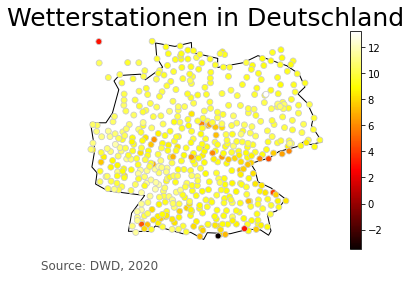

In [0]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
variable = 'temperature_day'
# set the range for the choropleth
vmin, vmax = -5, 15
# create figure and axes for Matplotlib
#fig, ax = plt.subplots(1, figsize=(10, 6))
ax = world[world.name=='Germany'].plot(
    color='white', edgecolor='black')
ax.axis('off')
ax.set_title('Wetterstationen in Deutschland', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: DWD, 2020',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
agg_data.plot(column=variable, cmap='hot', legend=True , linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()

In [0]:
data['messdatum_date'] = pd.to_datetime(data['messdatum_date'])
data['weekday'] = data['messdatum_date'].dt.day_name()
data

In [0]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekname_data = data.groupby('weekday').mean().reindex(cats) 
weekname_data[['temperature_day']].plot()

In [0]:
# get all Kreis (Landkreis + Stadtkreis) Shapes
kreis_spatial = gpd.read_file(base_dir + 'landkreise-in-germany.geojson')
#landkreis_spatial = gpd.read_file(base_dir + 'deutschlandGeoJSON/4_kreise/3_mittel.geo.json')


In [0]:
# get population for landkreise
landkreis_population = pd.read_csv(base_dir + 'landkreise.csv', thousands='.')
landkreis_population = landkreis_population.rename(columns={"KrS": "cca_2"})
landkreis_population['cca_2'] = landkreis_population['cca_2'].astype(str)
landkreis_population['cca_2'] = landkreis_population['cca_2'].apply(lambda x: x.zfill(5))

In [0]:
# get population for stadtkreise
stadtkreis_population = pd.read_csv(base_dir + 'stadtkreise.csv', thousands='.')
stadtkreis_population = stadtkreis_population.rename(columns={'2009':'Einw', 'Kreisfreie Stadt':'name_2'})

In [0]:
# firstly, merge all shapes data with landkreis population dataa
landkreis_data = landkreis_spatial.merge(landkreis_population, on = 'cca_2', how = 'left')

In [0]:
# secondly, merge resulting data with stadtkreis population data
kreis_data = landkreis_data.merge(stadtkreis_population, on = 'name_2', how = 'left')
# select relevant columns
kreis_data = kreis_data[['name_2','type_2','geometry','BevD','Einw_x','Einw_y']]
# replace NAs
kreis_data['Einw_x'] = kreis_data['Einw_x'].fillna(0)
kreis_data['Einw_y'] = kreis_data['Einw_y'].fillna(0)
# Combine landkreis and stadtkreis population columns into one column
kreis_data['Einw'] = kreis_data['Einw_x'] + kreis_data['Einw_y']
kreis_data

In [0]:
#filter  by state
#agg_data_stations = agg_data[agg_data.bundesland == 'Bayern']

#filter by landkreis (other polygon)
polygon = kreis_data[kreis_data.name_2 == 'Region Hannover'].geometry.iloc[0]
agg_data_stations = agg_data[agg_data['geom_station'].within(polygon)]


agg_data_stations = agg_data_stations[['stationsname','bundesland','geom_station']]

In [0]:
# add Stadtkreis/Landkreis to weather stations data
kreise = []
for index, row in agg_data.iterrows():  
  kreis = kreis_data[kreis_data['geometry'].contains(row['geom_station'])]
  if len(kreis) > 0:
    kreise.append(kreis.name_2.iloc[0])
  else:
    kreise.append('')
agg_data['Landkreis'] = kreise


In [0]:
#clean up data and store csv
agg_data[['von_datum','bis_datum','stationshoehe_x','geobreite_x','geolaenge_x','stationsname','Landkreis']].to_csv(base_dir + 'stations+counties.csv')

In [0]:
# once the landkreis/stadtkreis is identified for each weather station, we can aggregate now on kreis level
kreis_agg = agg_data.groupby('Landkreis').mean().reset_index()
kreis_agg = kreis_agg.rename(columns={'Landkreis':'name_2'})


In [216]:
# Create map focussed on Germany
m = folium.Map(location=[51.3, 10.1], zoom_start=6)  # This zooms the map to focus on germany (coods 51.3, 10.1)

# Add federal states overlay
germany_political = base_dir + 'deutschlandGeoJSON/4_kreise/2_hoch.geo.json'

choropleth = folium.Choropleth(
    geo_data = kreis_data,
    geo_str = 'choropleth',
    data = kreis_agg, #kreis_data,
    columns= ['name_2','temperature_day'], #['name_2', 'Einw'],
    key_on = 'feature.properties.name_2',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Temperature (celsius)',
    highlight=True
).add_to(m)

# Add station markers from GeoPandas data frame
m.add_child(folium.features.GeoJson(stations))

folium.LayerControl().add_to(m)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name_2'], labels=False)
)

# Display the map
m

Output hidden; open in https://colab.research.google.com to view.

In [0]:
'''
kreis_data =  gpd.read_file(base_dir + '3_mittel.geo.json')
kreis_data

table_name = "some_table"

# de#clare connection instance
conn = connect(
    #dbname = "some_db",
    user = "postgres",
    host = "193.196.37.97",
    password = "SDAPraktikum2020"
)

# declare a cursor object from the connection
cursor = conn.cursor()

 execute an SQL statement using the psycopg2 cursor object
cursor.execute(f"SELECT * FROM {table_name};")

 enumerate() over the PostgreSQL records
for i, record in enumerate(cursor):
    print ("\n", type(record))
    print ( record )

# close the cursor object to avoid memory leaks
cursor.close()

# close the connection as well
conn.close()

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(host="193.196.37.97", user="postgres", password="SDAPraktikum2020")
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT * FROM *')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')


if __name__ == '__main__':
    connect()

'''